<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/11_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 9.6 MB/s 
     |████████████████████████████████| 1.2 MB 55.4 MB/s 
     |████████████████████████████████| 4.4 MB 57.2 MB/s 
     |████████████████████████████████| 362 kB 80.8 MB/s 
     |████████████████████████████████| 1.1 MB 77.4 MB/s 
     |████████████████████████████████| 140 kB 78.6 MB/s 
     |████████████████████████████████| 212 kB 60.3 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 596 kB 71.8 MB/s 
     |████████████████████████████████| 127 kB 75.3 MB/s 
     |████████████████████████████████| 144 kB 75.5 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 77.9 MB/s 
     |████████████████████████████████| 6.6 MB 64.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10

In [9]:
#hide
from fastbook import *
from IPython.display import display,HTML
from fastai.text.all import *

# Transfer learning on text

In order to be able to use unstructured text for a downstream task, we can leverage a pretrained model on massive amounts of text instead of starting from scratch. The models use to encode multiple aspects of language and text in general are called language models.



What we call a language model is a model that has been trained to guess what the next word in a text is (having read the ones before). This kind of task is called *self-supervised learning*: we do not need to give labels to our model, just feed it lots and lots of texts. It has a process to automatically get labels from the data, and this task isn't trivial: to properly guess the next word in a sentence, the model will have to develop an understanding of the English (or other) language. Self-supervised learning can also be used in other domains; for instance, see ["Self-Supervised Learning and Computer Vision"](https://www.fast.ai/2020/01/13/self_supervised/) for an introduction to vision applications. Self-supervised learning is not usually used for the model that is trained directly, but instead is used for pretraining a model used for transfer learning.

> jargon: Self-supervised learning: Training a model using labels that are embedded in the independent variable, rather than requiring external labels. For instance, training a model to predict the next word in a text.

The pretrained language model we will used here was pretrained on Wikipedia. We can get great results by directly fine-tuning this language model to our downstream task, but with one extra step, we can do even better. The Wikipedia English is slightly different from language used in your specific application, so instead of jumping directly to the classifier, we could fine-tune our pretrained language model our own corpus and then use *that* as the base for our downstream task.

Even if our language model knows the basics of the language we are using in the task (e.g., our pretrained model is in English), it helps to get used to the style of the corpus we are targeting. It may be more informal language, or more technical, with new words to learn or different ways of composing sentences. 

This is known as the Universal Language Model Fine-tuning (ULMFit) approach. The [paper](https://arxiv.org/abs/1801.06146) showed that this extra stage of fine-tuning of the language model, prior to transfer learning to a classification task, resulted in significantly better predictions. Using this approach, we have three stages for transfer learning in NLP, as summarized here:.

<img alt="Diagram of the ULMFiT process" width="700" caption="The ULMFiT process" id="ulmfit_process" src="https://github.com/fastai/fastbook/blob/master/images/att_00027.png?raw=1">

## Text Preprocessing

It's not at all obvious how we're going to use what we've learned so far to build a language model. Sentences can be different lengths, and documents can be very long. So, how can we predict the next word of a sentence using a neural network? Let's find out!

We've already seen how categorical variables can be used as independent variables for a neural network ([categorical embeddings]([https://alanfortunysicart.blogspot.com/2022/07/fastai-deep-learning-journey-part-10.html)). 

We can do nearly the same thing with text! What is new is the idea of a sequence. First we concatenate all of the documents in our dataset into one big long string and split it into words, giving us a very long list of words (or "tokens"). Our independent variable will be the sequence of words starting with the first word in our very long list and ending with the second to last, and our dependent variable will be the sequence of words starting with the second word and ending with the last word. 

Our vocab will consist of a mix of common words that are already in the vocabulary of our pretrained model and new words specific to our corpus. Our embedding matrix will be built accordingly: for words that are in the vocabulary of our pretrained model, we will take the corresponding row in the embedding matrix of the pretrained model; but for new words we won't have anything, so we will just initialize the corresponding row with a random vector.

### Word Tokenization with fastai

Rather than providing its own tokenizers, fastai instead provides a consistent interface to a range of tokenizers in external libraries. Tokenization is an active field of research, and new and improved tokenizers are coming out all the time, so the defaults that fastai uses change too. However, the API and options shouldn't change too much, since fastai tries to maintain a consistent API even as the underlying technology changes.

Let's try it out with the good reads data set [good books dataset](https://www.kaggle.com/datasets/meetnaren/goodreads-best-books) containing book descriptions and ratings:

In [4]:
import pathlib 
path = pathlib.Path('/content/gdrive/MyDrive/NLP/')

In [ ]:
#!unzip '/content/gdrive/MyDrive/NLP/book_data.csv (2).zip' -d '/content/gdrive/MyDrive/NLP'

Archive:  /content/gdrive/MyDrive/NLP/book_data.csv (2).zip
  inflating: /content/gdrive/MyDrive/NLP/book_data.csv  


In [5]:
# load the labels
df = pd.read_csv('/content/gdrive/MyDrive/NLP/book_data.csv')

In [8]:
# keep only the description and rating
df = df[['book_desc','book_rating']]

In [9]:
# drop na recors
df = df.dropna()

In [10]:
#validate same amount of complete records
df.count()

book_desc      52970
book_rating    52970
dtype: int64

As this data set contains multiple languages, the following code filter out the ones in english

In [ ]:

# install and import languague detector
!pip install langdetect
from langdetect import detect

In [12]:
# detect english descriptions and keep only those
def detect_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False

df = df[df['book_desc'].apply(detect_en)]

Save the data frame after processing, as language detect take a few min

In [13]:
#df.to_pickle("/content/gdrive/MyDrive/NLP/english_books.pkl")

In [25]:
df = pd.read_pickle("/content/gdrive/MyDrive/NLP/english_books.pkl")

As we write this post, the default English word tokenizer for fastai uses a library called *spaCy*. It has a sophisticated rules engine with special rules for URLs, individual special English words, and much more. Rather than directly using `SpacyTokenizer`, however, we'll use `WordTokenizer`, since that will always point to fastai's current default word tokenizer (which may not necessarily be spaCy, depending when you're reading this).

In [27]:
txt = df.loc[0,'book_desc'][:50]

In [28]:
spacy = WordTokenizer()
toks = first(spacy([txt]))
print(coll_repr(toks, 30))

(#9) ['Winning','will','make','you','famous','.','Losing','means','certain']


As you see, spaCy has mainly just separated out the words and punctuation. But it does something else here too: it has split "it's" into "it" and "'s". That makes intuitive sense; these are separate words, really. Tokenization is a surprisingly subtle task, when you think about all the little details that have to be handled. Fortunately, spaCy handles these pretty well for us—for instance, here we see that "." is separated when it terminates a sentence, but not in an acronym or number:

fastai then adds some additional functionality to the tokenization process with the `Tokenizer` class:

In [29]:
tkn = Tokenizer(spacy)
print(coll_repr(tkn(txt), 31))

(#12) ['xxbos','xxmaj','winning','will','make','you','famous','.','xxmaj','losing','means','certain']


Notice that there are now some tokens that start with the characters "xx", which is not a common word prefix in English. These are *special tokens*.

For example, the first item in the list, `xxbos`, is a special token that indicates the start of a new text ("BOS" is a standard NLP acronym that means "beginning of stream"). By recognizing this start token, the model will be able to learn it needs to "forget" what was said previously and focus on upcoming words.

These special tokens don't come from spaCy directly. They are there because fastai adds them by default, by applying a number of rules when processing text. These rules are designed to make it easier for a model to recognize the important parts of a sentence. In a sense, we are translating the original English language sequence into a simplified tokenized language—a language that is designed to be easy for a model to learn.

Here are some of the main special tokens you'll see:

- `xxbos`:: Indicates the beginning of a text (here, a review)
- `xxmaj`:: Indicates the next word begins with a capital (since we lowercased everything)
- `xxunk`:: Indicates the word is unknown

### Numericalization with fastai

*Numericalization* is the process of mapping tokens to integers. The steps are basically identical to those necessary to create a `Category` variable, such as the dependent variable of digits in MNIST:

1. Make a list of all possible levels of that categorical variable (the vocab).
1. Replace each level with its index in the vocab.

Let's take a look at this in action on the word-tokenized text we saw earlier:

In [30]:
toks = tkn(txt)
print(coll_repr(tkn(txt), 31))

(#12) ['xxbos','xxmaj','winning','will','make','you','famous','.','xxmaj','losing','means','certain']


Just like with `SubwordTokenizer`, we need to call `setup` on `Numericalize`; this is how we create the vocab. That means we'll need our tokenized corpus first. Since tokenization takes a while, it's done in parallel by fastai; but for this manual walkthrough, we'll use a small subset:

In [31]:
txts = df.loc[:2000,'book_desc']

In [32]:
toks200 = txts[:200].map(tkn)
toks200[0]

(#244) ['xxbos','xxmaj','winning','will','make','you','famous','.','xxmaj','losing'...]

We can pass this to `setup` to create our vocab:

In [33]:
num = Numericalize()
num.setup(toks200)
coll_repr(num.vocab,20)

"(#1608) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj',',','the','and','of','.','a','to','in','is','-','his'...]"

Our special rules tokens appear first, and then every word appears once, in frequency order. The defaults to `Numericalize` are `min_freq=3,max_vocab=60000`. `max_vocab=60000` results in fastai replacing all words other than the most common 60,000 with a special *unknown word* token, `xxunk`. This is useful to avoid having an overly large embedding matrix, since that can slow down training and use up too much memory, and can also mean that there isn't enough data to train useful representations for rare words. However, this last issue is better handled by setting `min_freq`; the default `min_freq=3` means that any word appearing less than three times is replaced with `xxunk`.

fastai can also numericalize your dataset using a vocab that you provide, by passing a list of words as the `vocab` parameter.


In [34]:
nums = num(toks)[:20]; nums

TensorText([  2,   8, 283,  52, 190,  79, 247,  13,   8, 854, 664, 855])

Now that we have numbers, we need to put them in batches for our model.

### Putting Our Texts into Batches for a Language Model

When dealing with images, we needed to resize them all to the same height and width before grouping them together in a mini-batch so they could stack together efficiently in a single tensor. Here it's going to be a little different, because one cannot simply resize text to a desired length. Also, we want our language model to read text in order, so that it can efficiently predict what the next word is. This means that each new batch should begin precisely where the previous one left off.

Suppose we have the following text:

> : In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while.

The tokenization process will add special tokens and deal with punctuation to return this text:

> : xxbos xxmaj in this chapter , we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface . xxmaj first we will look at the processing steps necessary to convert text into numbers and how to customize it . xxmaj by doing this , we 'll have another example of the preprocessor used in the data block xxup api . \n xxmaj then we will study how we build a language model and train it for a while .

We now have 90 tokens, separated by spaces. Let's say we want a batch size of 6. We need to break this text into 6 contiguous parts of length 15:

In [35]:
#hide_input
stream = "In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while."
tokens = tkn(stream)
bs,seq_len = 6,15
d_tokens = np.array([tokens[i*seq_len:(i+1)*seq_len] for i in range(bs)])
dfs = pd.DataFrame(d_tokens)
display(HTML(dfs.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter,",",we,will,go,back,over,the,example,of,classifying
movie,reviews,we,studied,in,chapter,1,and,dig,deeper,under,the,surface,.,xxmaj
first,we,will,look,at,the,processing,steps,necessary,to,convert,text,into,numbers,and
how,to,customize,it,.,xxmaj,by,doing,this,",",we,'ll,have,another,example
of,the,preprocessor,used,in,the,data,block,xxup,api,.,\n,xxmaj,then,we
will,study,how,we,build,a,language,model,and,train,it,for,a,while,.


In a perfect world, we could then give this one batch to our model. But that approach doesn't scale, because outside of this toy example it's unlikely that a single batch containing all the texts would fit in our GPU memory (here we have 90 tokens, but all the IMDb reviews together give several million).

So, we need to divide this array more finely into subarrays of a fixed sequence length. It is important to maintain order within and across these subarrays, because we will use a model that maintains a state so that it remembers what it read previously when predicting what comes next. 

Going back to our previous example with 6 batches of length 15, if we chose a sequence length of 5, that would mean we first feed the following array:

In [36]:
#hide_input
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15:i*15+seq_len] for i in range(bs)])
dfs = pd.DataFrame(d_tokens)
display(HTML(dfs.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter
movie,reviews,we,studied,in
first,we,will,look,at
how,to,customize,it,.
of,the,preprocessor,used,in
will,study,how,we,build


Then this one:

In [37]:
#hide_input
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15+seq_len:i*15+2*seq_len] for i in range(bs)])
dfs = pd.DataFrame(d_tokens)
display(HTML(dfs.to_html(index=False,header=None)))

",",we,will,go,back
chapter,1,and,dig,deeper
the,processing,steps,necessary,to
xxmaj,by,doing,this,","
the,data,block,xxup,api
a,language,model,and,train


And finally:

In [38]:
#hide_input
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15+10:i*15+15] for i in range(bs)])
dfs = pd.DataFrame(d_tokens)
display(HTML(dfs.to_html(index=False,header=None)))

over,the,example,of,classifying
under,the,surface,.,xxmaj
convert,text,into,numbers,and
we,'ll,have,another,example
.,\n,xxmaj,then,we
it,for,a,while,.


The first step in our dataset will be to transform the individual texts into a stream by concatenating them together. 

We then cut this stream into a certain number of batches (which is our *batch size*). For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens. What is important is that we preserve the order of the tokens (so from 1 to 5,000 for the first mini-stream, then from 5,001 to 10,000...), because we want the model to read continuous rows of text (as in the preceding example). An `xxbos` token is added at the start of each during preprocessing, so that the model knows when it reads the stream when a new entry is beginning.

So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

This concludes all the preprocessing steps we need to apply to our data. We are now ready to train our text classifier.

## Training a Text Classifier

As we saw at the beginning of this chapter, there are two steps to training a state-of-the-art text classifier using transfer learning: first we need to fine-tune our language model pretrained on Wikipedia to our corpus, and then we can use that model to train a classifier.

As usual, let's start with assembling our data.

### Language Model Using DataBlock

fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. All of the arguments that can be passed to `Tokenize` and `Numericalize` can also be passed to `TextBlock`. In the next chapter we'll discuss the easiest ways to run each of these steps separately, to ease debugging—but you can always just debug by running them manually on a subset of your data as shown in the previous sections. And don't forget about `DataBlock`'s handy `summary` method, which is very useful for debugging data issues.

Here's how we use `TextBlock` to create a language model, using fastai's defaults:

In [39]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('book_desc', is_lm=True),get_x=ColReader('text'))

dls_lm = dls_lm.dataloaders(df, bs=64)
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj in this iridescent gem of a novel , xxmaj louis de xxmaj xxunk returns to the territory he mapped so well in xxmaj the xxmaj war of xxmaj don xxmaj emmanuel 's xxmaj nether xxmaj parts , a xxmaj south xxmaj american country of resplendent eccentricity , gargantuan corruption , and terrifying violence , where the ordinary machinery of government has rusted and the only thing that works is magic","xxmaj in this iridescent gem of a novel , xxmaj louis de xxmaj xxunk returns to the territory he mapped so well in xxmaj the xxmaj war of xxmaj don xxmaj emmanuel 's xxmaj nether xxmaj parts , a xxmaj south xxmaj american country of resplendent eccentricity , gargantuan corruption , and terrifying violence , where the ordinary machinery of government has rusted and the only thing that works is magic ."
1,"amaranth , is seen through the eyes of an aging and sick warrior , xxmaj admiral xxmaj julian xxmaj stansfield , as he carries the weight of his country on his shoulders . xxmaj handicapped by personal grief and medical illness , he directs the xxmaj united xxmaj states through a major conventional world war . xxmaj he worries for his three sons who are all scattered around the planet in their",", is seen through the eyes of an aging and sick warrior , xxmaj admiral xxmaj julian xxmaj stansfield , as he carries the weight of his country on his shoulders . xxmaj handicapped by personal grief and medical illness , he directs the xxmaj united xxmaj states through a major conventional world war . xxmaj he worries for his three sons who are all scattered around the planet in their respective"


Now that our data is ready, we can fine-tune the pretrained language model.

### Fine-Tuning the Language Model

To convert the integer word indices into activations that we can use for our neural network, we will use embeddings, just like we did for collaborative filtering and tabular modeling. Then we'll feed those embeddings into a *recurrent neural network* (RNN), using an architecture called *AWD-LSTM*. As we discussed earlier, the embeddings in the pretrained model are merged with random embeddings added for words that weren't in the pretraining vocabulary. This is handled automatically inside `language_model_learner`:

In [40]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

The loss function used by default is cross-entropy loss, since we essentially have a classification problem (the different categories being the words in our vocab). The *perplexity* metric used here is often used in NLP for language models: it is the exponential of the loss (i.e., `torch.exp(cross_entropy)`). We  also include the accuracy metric, to see how many times our model is right when trying to predict the next word, since cross-entropy (as we've seen) is both hard to interpret, and tells us more about the model's confidence than its accuracy.

Let's go back to the process diagram from the beginning of this chapter. The first arrow has been completed for us and made available as a pretrained model in fastai, and we've just built the `DataLoaders` and `Learner` for the second stage. Now we're ready to fine-tune our language model!

It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process. Since `fine_tune` doesn't do that for us, we'll use `fit_one_cycle`. Just like `vision_learner`, `language_model_learner` automatically calls `freeze` when using a pretrained model (which is the default), so this will only train the embeddings (the only part of the model that contains randomly initialized weights—i.e., embeddings for words that are in our own vocab, but aren't in the pretrained model vocab):

In [48]:
# Train for one cycle only for the randomly initialized weights (words that are not in the pretrained model)
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.112721,3.988225,0.308627,53.959015,16:20


### Saving and Loading Models

You can easily save the state of your model like so:

In [49]:
learn.save('/content/gdrive/MyDrive/NLP/1epoch')

Path('/content/gdrive/MyDrive/NLP/1epoch.pth')

This will create a file named *1epoch.pth*. If you want to load your model in another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [41]:
learn = learn.load('/content/gdrive/MyDrive/NLP/1epoch')

Once the initial training has completed, we can continue fine-tuning the model after unfreezing:

In [51]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.737280,3.859213,0.325504,47.428028,16:56
1,3.685014,3.810924,0.330890,45.192158,17:05
2,3.570149,3.761614,0.337602,43.017784,17:10
3,3.411179,3.748586,0.341668,42.460987,16:57
4,3.280570,3.750224,0.345136,42.530613,17:01
5,3.104637,3.752321,0.348173,42.619869,17:08
6,2.925128,3.771851,0.349610,43.460419,17:02
7,2.770674,3.802989,0.350138,44.835018,17:00
8,2.671160,3.825079,0.349861,45.836411,17:03
9,2.587893,3.842176,0.349316,46.626823,17:04


Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [52]:
learn.save_encoder('/content/gdrive/MyDrive/NLP/finetuned')

> jargon: Encoder: The model not including the task-specific final layer(s). This term means much the same thing as _body_ when applied to vision CNNs, but "encoder" tends to be more used for NLP and generative models.

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### Creating the Classifier DataLoaders

We're now moving from language model fine-tuning to classifier fine-tuning. To recap, a language model predicts the next word of a document, so it doesn't need any external labels. A classifier, however, predicts some external label.

This means that the structure of our `DataBlock` for NLP classification will look very familiar. It's actually nearly the same as we've seen for the many image classification datasets we've worked with.


Let's crete from the rating the categorical variable for positive rating above 3.5 over 5 and negative below that.

In [42]:
df['book_rating'] = np.where(df['book_rating'] > 3.5, 'Pos', 'Neg')

We can now create the data block for the classification task

In [43]:
imdb_clas = DataBlock(
    blocks=(TextBlock.from_df('book_desc', seq_len=72,vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('book_rating'))

dls_clas = imdb_clas.dataloaders(df, bs=64)
dls_clas.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj spiritus xxmaj mundi by xxmaj robert xxmaj sheppard , nominated for the prestigious 2014 xxmaj pushcart xxmaj prize for xxmaj literature , consists of xxmaj spiritus xxmaj mundi , the novel — book xxup i , and xxmaj spiritus xxmaj mundi , the romance — book xxup ii . xxmaj book xxmaj i ’s espionage - terror - political - religious thriller - action criss - crosses the globe from xxmaj beijing to xxmaj london to xxmaj washington , xxmaj mexico xxmaj city and xxmaj jerusalem presenting a vast panorama of the contemporary international world , including compelling action , deep and realistic characters and surreal adventures , while xxmaj book xxup ii xxunk the setting and scope into a fantasy ( though still rooted in the real ) adventure where the protagonists embark on a quest to the realms of xxmaj middle xxmaj earth and its xxmaj",Pos
1,"xxbos xxmaj home is where the heart is … . xxmaj five authors , five tales spanning centuries all set in the same mansion on the water … \t xxmaj to some of us , home is everything . xxmaj our connection to the past , a place in which to build a future , the only place to run when the world we know falls apart … . \t xxmaj for xxmaj livie xxmaj harrington , xxmaj bliss is everything . xxmaj it ’s a house comprised of memories , the last remaining link to her past . xxmaj in a life shattered by the war between the states , xxmaj bliss becomes xxmaj livie ’s anchor , the driving force behind her desperate scramble to rebuild a lost family fortune . xxmaj she ’s lost her parents , her only love , and her brother is off fighting",Pos


We validate that the vocabulary of the language model and the downstream task model is the same:

In [44]:
len(dls_clas.vocab[0])

51296

In [46]:
len(dls_lm.vocab)

51296

Looking at the `DataBlock` definition, every piece is familiar from previous data blocks we've built, with two important exceptions:

- `TextBlock.from_df` no longer has the `is_lm=True` parameter.
- We pass the `vocab` we created for the language model fine-tuning.

The reason that we pass the `vocab` of the language model is to make sure we use the same correspondence of token to index. Otherwise the embeddings we learned in our fine-tuned language model won't make any sense to this model, and the fine-tuning step won't be of any use.

By passing `is_lm=False` (or not passing `is_lm` at all, since it defaults to `False`) we tell `TextBlock` that we have regular labeled data, rather than using the next tokens as labels. There is one challenge we have to deal with, however, which is to do with collating multiple documents into a mini-batch. 

Remember, PyTorch `DataLoader`s need to collate all the items in a batch into a single tensor, and a single tensor has a fixed shape (i.e., it has some particular length on every axis, and all items must be consistent). This should sound familiar: we had the same issue with images. In that case, we use padding as cropping and other augmentation do not make sense!

We will expand the shortest texts to make them all the same size. To do this, we use a special padding token that will be ignored by our model. Additionally, to avoid memory issues and improve performance, we will batch together texts that are roughly the same lengths (with some shuffling for the training set). We do this by (approximately, for the training set) sorting the documents by length prior to each epoch. The result of this is that the documents collated into a single batch will tend to be of similar lengths. We won't pad every batch to the same size, but will instead use the size of the largest document in each batch as the target size. 

The sorting and padding are automatically done by the data block API for us when using a `TextBlock`, with `is_lm=False`. (We don't have this same issue for language model data, since we concatenate all the documents together first, and then split them into equally sized sections.)

We can now create a model to classify our texts:

In [47]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

The final step prior to training the classifier is to load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded:

In [53]:
learn = learn.load_encoder('/content/gdrive/MyDrive/NLP/finetuned')

### Fine-Tuning the Classifier

The last step is to train with discriminative learning rates and *gradual unfreezing*. In computer vision we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference:

SuggestedLRs(valley=0.0014454397605732083)

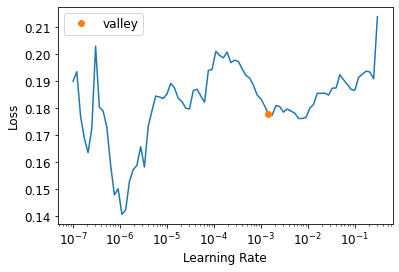

In [54]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(1, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.180403,0.185377,0.950880,01:28


In just one epoch we get the same result as our training in <<chapter_intro>>: not too bad! We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [56]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(0.001/(2.6**4),0.001))

epoch,train_loss,valid_loss,accuracy,time
0,0.189899,0.183871,0.950989,01:44


And finally, the whole model!

In [57]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(0.001/(2.6**4),0.001))

epoch,train_loss,valid_loss,accuracy,time
0,0.175932,0.185523,0.950772,03:09
1,0.178015,0.184758,0.950446,03:09
2,0.166121,0.184803,0.950120,03:10
3,0.156078,0.190090,0.950337,03:10
4,0.148468,0.200270,0.948815,03:09
5,0.131827,0.210003,0.946533,03:10
6,0.127835,0.219702,0.947185,03:09
7,0.108819,0.228468,0.945990,03:10
8,0.105836,0.231379,0.947294,03:10
9,0.109468,0.234607,0.946533,03:10


We reached 95% accuracy, which is surprising as we are using only book description, is really interesting that it was able to find which books will have very high and low review. 

Using a pretrained model let us build a fine-tuned language model that was pretty powerful.

## Conclusion

In this chapter we explored the last application covered out of the box by the fastai library: text. We saw  language models that can be used and fine tuned to any downstream task. To build a state-of-the art classifier, we used a pretrained language model, fine-tuned it to the corpus of our task, then used its body (the encoder) with a new head to do the classification.

